# Visualize AMASS dataset

### Prepare

In [ ]:
%cd ../
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

In [2]:
# Load Configs
config = json.load(open("config.json")) 
ds_config = config['dataset']

In [3]:
# Visualization helper

def get_gradation(i):
	f = np.array([1, 0, 0.2])
	t = np.array([0, 1, 0.2])
	return np.expand_dims(i, -1) * (t - f) + f

def vis(joints, kintree=None):
	if kintree is not None:
		c = np.zeros((22,))
		for i in range(1, 22):
			c[i] = c[kintree[0, i]] + 1
		c = get_gradation(c/np.max(c))

	max_range = (np.max(joints.T, -1)-np.min(joints.T, -1)).max()/2
	mid_x, mid_y, mid_z = (np.max(joints.T, -1)+np.min(joints.T, -1))/2

	fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=50, subplot_kw={'projection': "3d"})
	for i in axs:
		for j in i:
			j.set_xlim(mid_x - max_range, mid_x + max_range)
			j.set_ylim(mid_y - max_range, mid_y + max_range)
			j.set_zlim(mid_z - max_range, mid_z + max_range)
			j.scatter3D(*joints.T, s=10)
			if kintree is not None:
				j.quiver3D(*joints[kintree[0, 1:22]].T, *(joints[1:22]-joints[kintree[0, 1:22]]).T, color=c)
	axs[0,0].view_init(elev=90, azim=0)
	axs[0,1].view_init(elev=45, azim=45)
	axs[1,0].view_init(elev=0, azim=0)
	axs[1,1].view_init(elev=0, azim=90)
	plt.show()

## Load Datasets
AMASS object has functions to get each types of processed Dataset

All of functions returns `((train_input, train_labels), (test_input, test_labels))`

In [4]:
import dataset

# Load and Create AMASS DS object
amass = dataset.AMASS(
	ds_config['amass_path'], 
	# whitelist=['MPI_Limits'], 
	whitelist=ds_config['whitelist'], 
	model_path=ds_config['model_filepath'],
	framerate_adjust=ds_config['framerate_adjust'] # to adjust framerate for sequence
	)

# make ds small for visualize purpose
amass.ds = amass.ds[:1]
amass.ds[0] = amass.ds[0].take(40)

model = np.load(ds_config['model_filepath'])

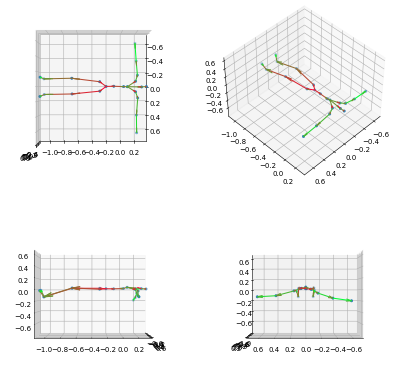

In [5]:
_, (test, testl) = amass.get_fullbody(True)
b = dataset.apply_trans(test.as_numpy_iterator().next(), model['kintree_table']).numpy()[:, :3, 3]

# Visualize trans applied joints
vis(b, model['kintree_table'])

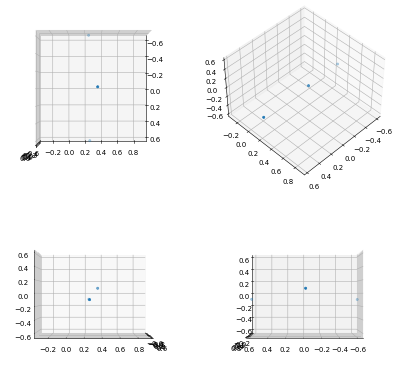

In [6]:
_, (hh, hhl) = amass.get_hh(True)
vis(hh.as_numpy_iterator().next()[:, :3, 3])

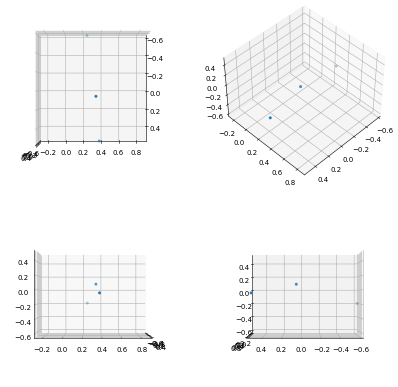

In [7]:
_, (hhs, hhsl) = amass.get_hh_sequence()
vis(hhs.as_numpy_iterator().next()[1, :, :3, 3])

In [8]:
print(testl.as_numpy_iterator().next().shape)
print(hhl.as_numpy_iterator().next().shape)
print(hhsl.as_numpy_iterator().next().shape)

(22, 3, 3)
(22, 3, 3)
(22, 3, 3)
